In [3]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from PIL import Image

from random import randint

import matplotlib.pyplot as plt
import gc
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from tensorflow.python.keras.utils import conv_utils
#from keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape 
import tensorflow as tf

from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

/local_scratch/slurm.288613/ipykernel_3498206/1385814484.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
2024-07-15 11:41:26.272284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 11:41:26.294596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 11:41:26.294627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been re

In [4]:

transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform_image=None, transform_mask=None):
        self.root_dir = root_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images_dir = os.path.join(root_dir, 'imgs')
        self.masks_dir = os.path.join(root_dir, 'masks')
        self.image_filenames = os.listdir(self.images_dir)
        
        self.image_filenames = [name for name in self.image_filenames if not name.startswith(".ipynb")]
        


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_name = os.path.join(self.masks_dir, self.image_filenames[idx].replace('img_', 'mask_').replace('.jpg', '.png'))
        
        

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('RGB')  # Convert to grayscale for single channel mask

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

In [6]:
# Transforms dataset
#transform = transforms.Compose([
#    transforms.Resize((256, 256)),  # Resize image
#    transforms.ToTensor(),
#])

# Define Transforms
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [7]:
# Defines dataset and dataloaders
train_dataset = CustomDataset(root_dir='CAVS/Main_Trail/Train', transform_image=transform_image, transform_mask=transform_mask)
test_dataset = CustomDataset(root_dir='CAVS/Main_Trail/Test', transform_image=transform_image, transform_mask=transform_mask)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
# Function to extract data from DataLoader
def extract_data_from_dataloader(dataloader):
    images_list = []
    masks_list = []
    
    for images, masks in tqdm(dataloader):
        images_list.append(images.numpy())  # Convert to numpy arrays
        masks_list.append(masks.numpy())    # Convert to numpy arrays
    
    # Stack the list of arrays into a single numpy array
    images_array = np.vstack(images_list)
    masks_array = np.vstack(masks_list)
    
    # Transpose the arrays to have shape (batch_size, height, width, channels)
    images_array = np.transpose(images_array, (0, 2, 3, 1))
    masks_array = np.transpose(masks_array, (0, 2, 3, 1))
    
    return images_array, masks_array

# Extract data from train and test dataloaders
train_images, train_masks = extract_data_from_dataloader(train_dataloader)
test_images, test_masks = extract_data_from_dataloader(test_dataloader)

# Assuming your masks are integer-encoded
#train_masks = to_categorical(train_masks, num_classes=3)
#test_masks = to_categorical(test_masks, num_classes=3)

# Create DataFrames
train_df = pd.DataFrame({'images': list(train_images), 'masks': list(train_masks)})
test_df = pd.DataFrame({'images': list(test_images), 'masks': list(test_masks)})


100%|██████████| 57/57 [00:01<00:00, 39.97it/s]


In [9]:
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)


train_df shape: (133, 2)
test_df shape: (57, 2)


TypeError: Invalid shape (256, 3, 256) for image data

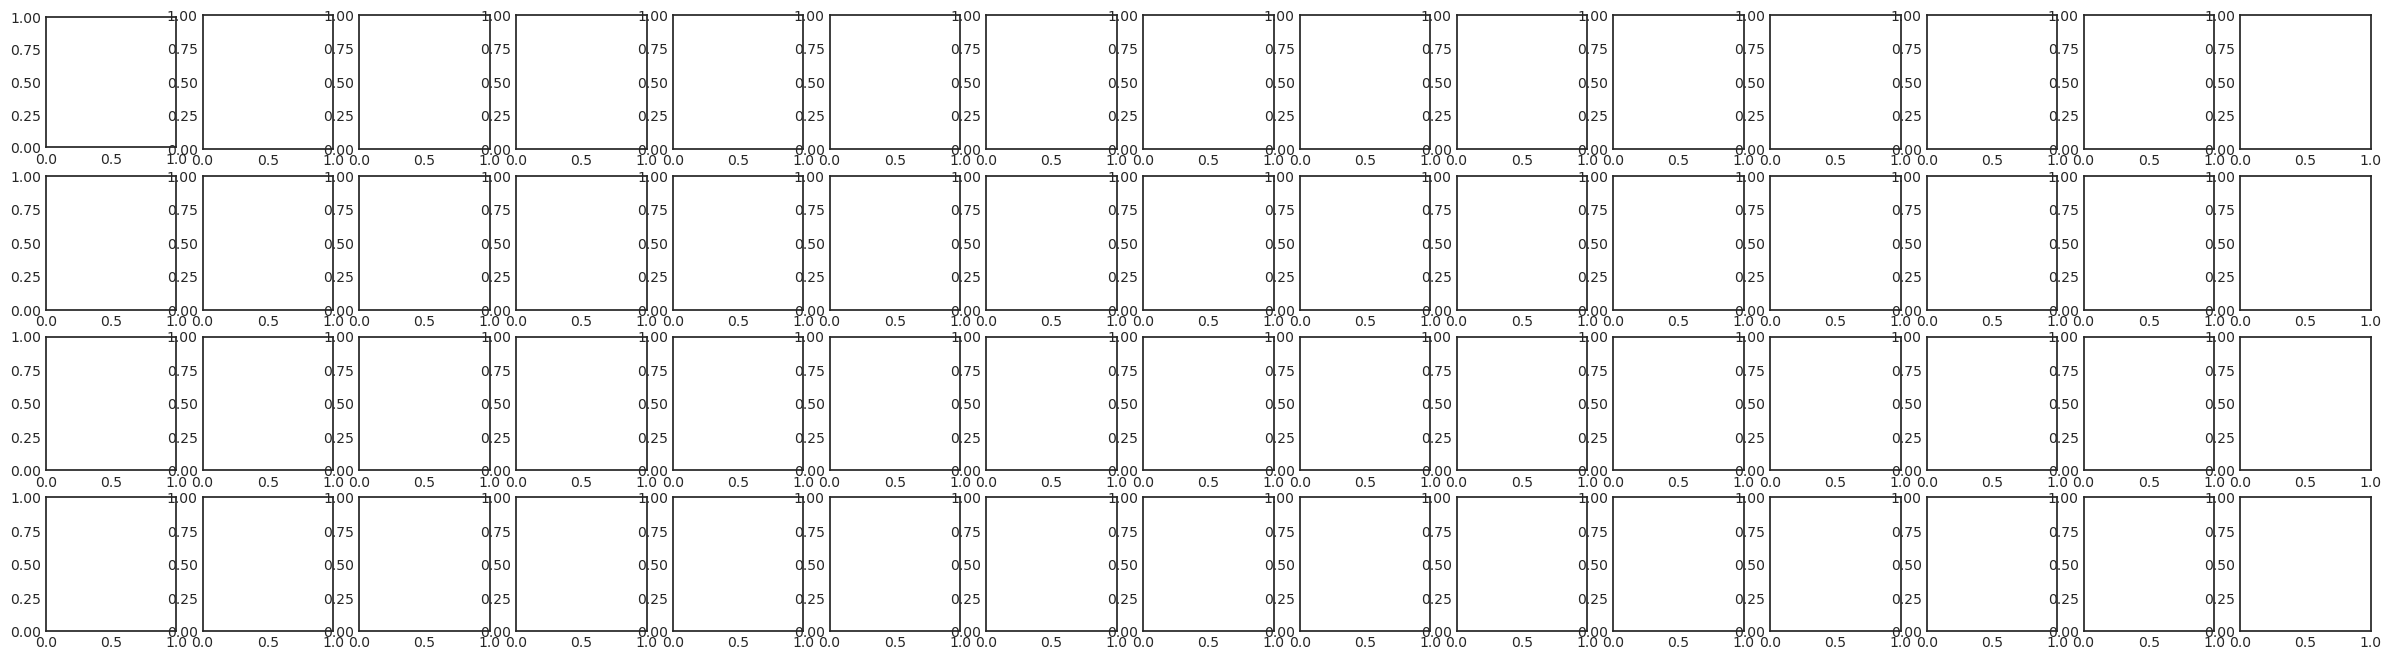

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define the maximum number of images to display and the grid dimensions
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)

# Create a subplot grid
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))

# Loop through the first `max_images` entries in the DataFrame
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks

    # Transpose the image to the correct shape (height, width, channels)
    img = img.transpose(1, 2, 0)
    mask = mask.transpose(1, 2, 0)

    # Combine masks into a single RGB image for visualization
    combined_mask = np.zeros_like(img)
    combined_mask[..., 0] = mask[..., 0]  # Red channel
    combined_mask[..., 1] = mask[..., 1]  # Green channel
    combined_mask[..., 2] = mask[..., 2]  # Blue channel

    # Get the subplot axis
    ax = axs[int(i / grid_width), i % grid_width]

    # Display the image
    ax.imshow(img, cmap="Greys")
    # Overlay the combined mask with some transparency
    ax.imshow(combined_mask, alpha=0.3)

    # Optionally, add text annotations (customize as needed)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

plt.suptitle("Red, Green, Blue")
plt.tight_layout()
plt.show()

In [ ]:
# Convert the images and masks to numpy arrays
#images = np.array(train_df.images.tolist())
#masks = np.array(train_df.masks.tolist())


# Split dataset
ids_train, ids_valid, x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.index.values,
    train_images,
    train_masks,
    test_size=0.2,
    stratify=None,  # Assuming no stratification is needed
    random_state=1337
)

In [ ]:
#Build Model
# Define the conv_block_simple function
def conv_block_simple(inputs, filters, name):
    x = Conv2D(filters, (3, 3), padding='same', name=f'{name}_conv')(inputs)
    x = BatchNormalization(name=f'{name}_bn')(x)
    x = Activation('relu', name=f'{name}_act')(x)
    return x

def conv_block_simple_no_bn(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

In [ ]:
# Clear previous sessions
tf.keras.backend.clear_session()

def get_unet_resnet(input_shape):
    resnet_base = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

    for l in resnet_base.layers:
        l.trainable = True
    
    conv1 = resnet_base.get_layer("activation_1").output
    conv2 = resnet_base.get_layer("activation_10").output
    conv3 = resnet_base.get_layer("activation_22").output
    conv4 = resnet_base.get_layer("activation_40").output
    conv5 = resnet_base.get_layer("activation_48").output

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = conv_block_simple(up6, 256, "conv6_1")
    conv6 = conv_block_simple(conv6, 256, "conv6_2")

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = conv_block_simple(up7, 192, "conv7_1")
    conv7 = conv_block_simple(conv7, 192, "conv7_2")

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = conv_block_simple(up8, 128, "conv8_1")
    conv8 = conv_block_simple(conv8, 128, "conv8_2")

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = conv_block_simple(up9, 64, "conv9_1")
    conv9 = conv_block_simple(conv9, 64, "conv9_2")

    up10 = UpSampling2D(size=(2, 2))(conv9)
    conv10 = conv_block_simple(up10, 32, "conv10_1")
    conv10 = conv_block_simple(conv10, 32, "conv10_2")
    conv10 = SpatialDropout2D(0.2)(conv10)
    x = Conv2D(1, (1, 1), activation="sigmoid", name="prediction")(conv10)
    
    model = Model(resnet_base.input, x)
    
    return model


In [ ]:
import warnings

from keras_applications.imagenet_utils import _obtain_input_shape
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
#from tensorflow.keras.engine import get_source_inputs
from tensorflow.python.keras.utils import layer_utils
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50

WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [ ]:
def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=(256, 256, 3),
             pooling=None, classes=1000):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either `None` (random initialization) or `imagenet` (pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top` as true, `classes` should be 1000')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='resnet50')

    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5', WEIGHTS_PATH, cache_subdir='models', md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', WEIGHTS_PATH_NO_TOP, cache_subdir='models', md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path, by_name=True)
    return model

In [ ]:
def relu6(x):
    return K.relu(x, max_value=6)

In [ ]:
input_shape = (3, 256, 256)
model = ResNet50(include_top=False, weights=None, input_shape=input_shape, classes=3)
#model.summary()

In [ ]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

# Define the custom IOU metric function
def my_iou_metric(y_true, y_pred):
    threshold = 0.5
    y_pred = K.cast(y_pred > threshold, dtype='float32')
    return MeanIoU(num_classes=2)(y_true, y_pred)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [ ]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
# Import the categorical crossentropy loss function
from tensorflow.keras.losses import categorical_crossentropy


In [ ]:
import gc
gc.enable()

In [ ]:
# Compile the model
model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=[my_iou_metric])

In [ ]:
# Transpose the dimensions of the images to match the expected shape for imshow
x_train_transposed = np.transpose(x_train, (0, 2, 3, 1))
y_train_transposed = np.transpose(y_train, (0, 2, 3, 1))

fig, axs = plt.subplots(2, 10, figsize=(15, 3))

for i in range(10):
    axs[0][i].imshow(x_train_transposed[i], cmap="Greys")
    axs[0][i].imshow(y_train_transposed[i], cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train_transposed[int(len(x_train_transposed)/2 + i)], cmap="Greys")
    axs[1][i].imshow(y_train_transposed[int(len(y_train_transposed)/2 + i)], cmap="Greens", alpha=0.3)

fig.suptitle("Top row: original images, bottom row: augmented images")
plt.show()

In [ ]:
x_train = np.repeat(x_train,3,axis=3)
x_valid = np.repeat(x_valid,3,axis=3)

# Ensure the training and validation data are in the correct shape
#assert x_train_aug.shape[1:] == (256, 256, 3)
#assert y_train_aug.shape[1:] == (256, 256, 3)
#assert x_valid.shape[1:] == (256, 256, 3)
#assert y_valid.shape[1:] == (256, 256, 3)

# Transpose the data to match the expected input shape
# Transpose the data back to the expected shape
#x_train_transposed_back = np.transpose(x_train_resized, (0, 3, 1, 2))
#x_valid_transposed_back = np.transpose(x_valid_resized, (0, 3, 1, 2))
#y_train_transposed_back = np.transpose(y_train_resized, (0, 3, 1, 2))
#y_valid_transposed_back = np.transpose(y_valid_resized, (0, 3, 1, 2))

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint("./model.keras", monitor='val_my_iou_metric', 
                                   mode='max', save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

epochs = 100
batch_size = 16

history = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid), 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr],
                    shuffle=True,
                    verbose=2)